In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

from concepts import concept_instances
from probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
game_data = load_game_data()
q_network, device = load_q_network_device()
q_network.to('cpu')

QNetwork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [4]:
ball_low = concept_instances['ball low (b)']
ball_left = concept_instances['ball left paddle (b)']
reward = concept_instances['reward (b)']
paddle_right = concept_instances['paddle x']
bricks_hit = concept_instances['bricks hit']
game_data = load_game_data()

In [5]:
layer = '5'
hyperparams = {
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 200,
    'lambda_l1': 0.0,
    'patience': 10
}

In [6]:
ball_low_probe, ball_low_score = train_probe(game_data, q_network, ball_low, layer, hyperparams)
ball_left_probe, ball_left_score = train_probe(game_data, q_network, ball_left, layer, hyperparams)
reward_probe, reward_score = train_probe(game_data, q_network, reward, layer, hyperparams)
paddle_right_probe, paddle_right_score = train_probe(game_data, q_network, paddle_right, layer, hyperparams)
bricks_hit_probe, bricks_hit_score = train_probe(game_data, q_network, bricks_hit, layer, hyperparams)

Layer 5 - Score: 0.9671
Layer 5 - Score: 0.8328
Layer 5 - Score: 0.8045
Layer 5 - Score: 0.9572
Layer 5 - Score: 0.9967


In [7]:
# sort images by activations and cav
def sort(images, acts, coefficients):
    norm = np.linalg.norm(coefficients)
    cav = - coefficients
    # sort images by cosine similarity of activations and cav
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: scipy.spatial.distance.cosine(x[1], cav), reverse=True)
    images, acts = zip(*images_acts)
    return images

In [8]:
def plot_images(images, n):
    # Determine the number of rows required for every 5 images per row
    rows = -(-n // 5)
    fig = plt.figure(figsize=(11, 3 * rows))
    for i in range(n):
        ax = fig.add_subplot(rows, 5, i+1)
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

In [9]:
def sort_images(concept, coefficients):
    images = concept.test_images
    _, test_acts_dict = q_network(torch.tensor(concept.test_obs), return_acts=True)
    test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
    test_acts = test_acts.reshape(len(test_acts), -1)

    images = sort(images, test_acts, coefficients)
    plot_images(images, 10)

### Ball low

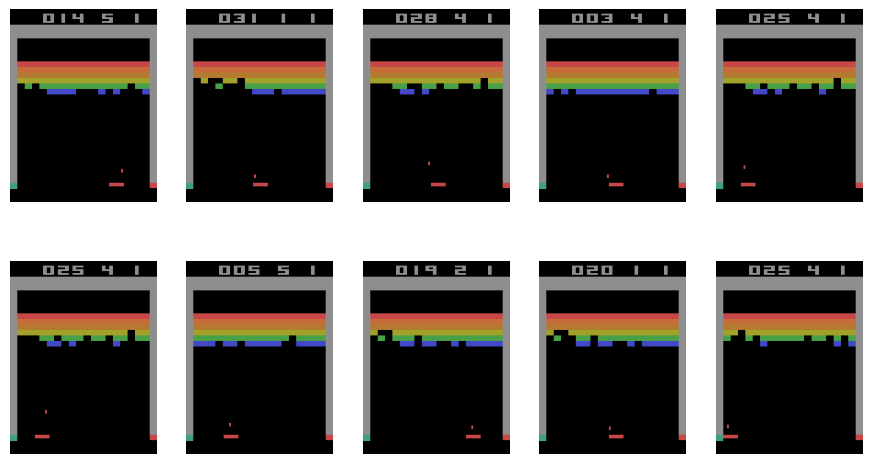

In [10]:
ball_low_coef = ball_low_probe[1].weight.squeeze(0).cpu().detach().numpy()
sort_images(ball_low, ball_low_coef)

### Ball Left for paddle

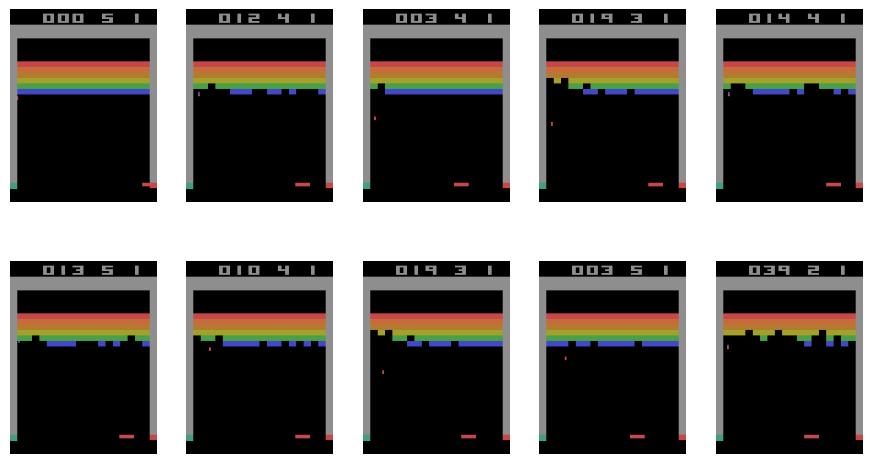

In [11]:
ball_left_coef = ball_left_probe[1].weight.squeeze(0).cpu().detach().numpy()
sort_images(ball_left, ball_left_coef)

### Reward

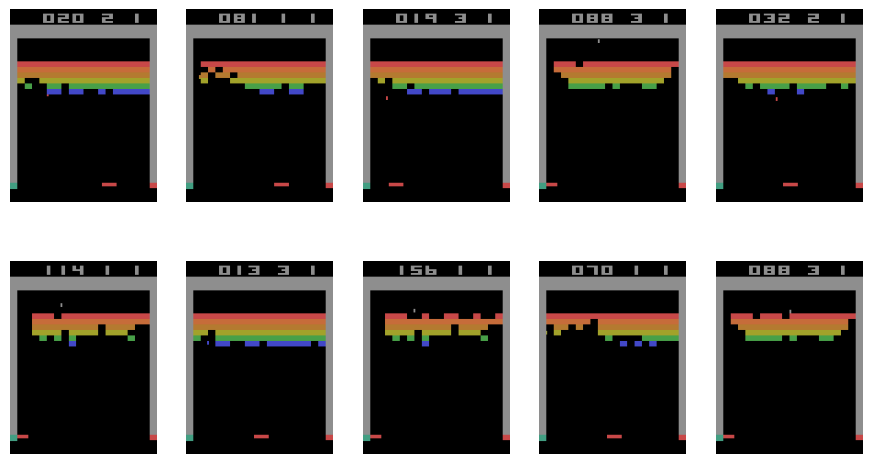

In [12]:
reward_coef = reward_probe[1].weight.squeeze(0).cpu().detach().numpy()
sort_images(reward, reward_coef)

### Paddle right (non binary)

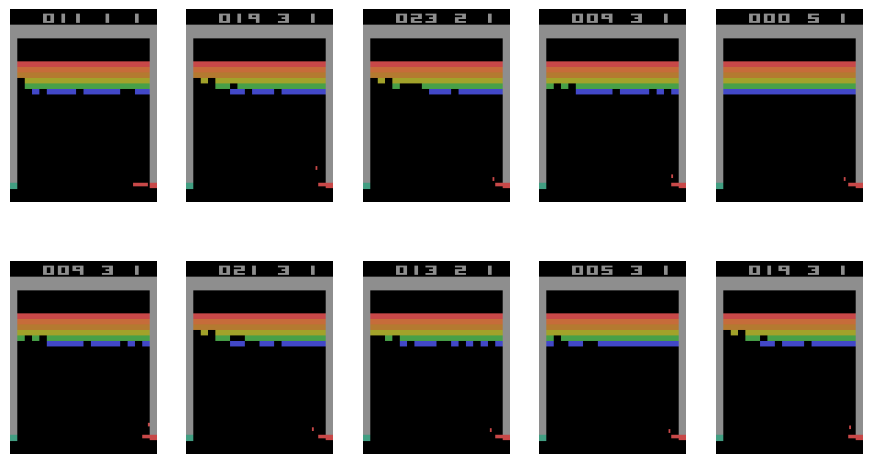

In [13]:
paddle_right_coef = paddle_right_probe[1].weight.squeeze(0).cpu().detach().numpy()
sort_images(paddle_right, paddle_right_coef)

### Bricks hit (non binary)

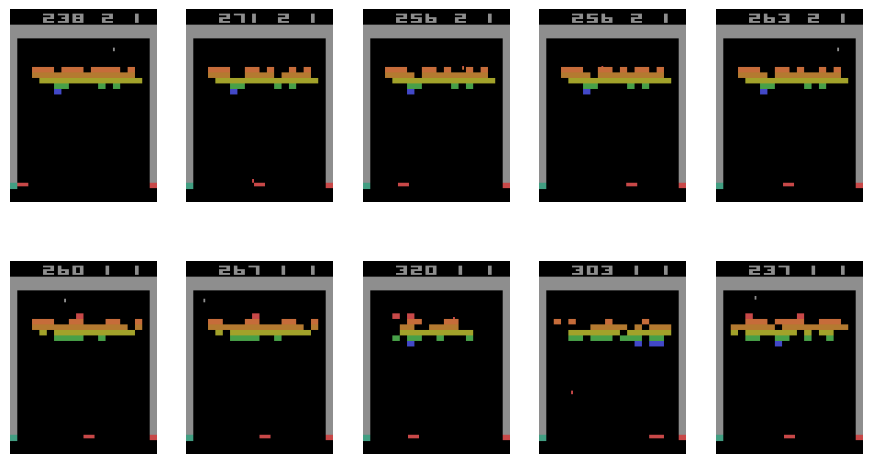

In [14]:
bricks_hit_coef = bricks_hit_probe[1].weight.squeeze(0).cpu().detach().numpy()
sort_images(bricks_hit, bricks_hit_coef)

### Ball left - Ball low

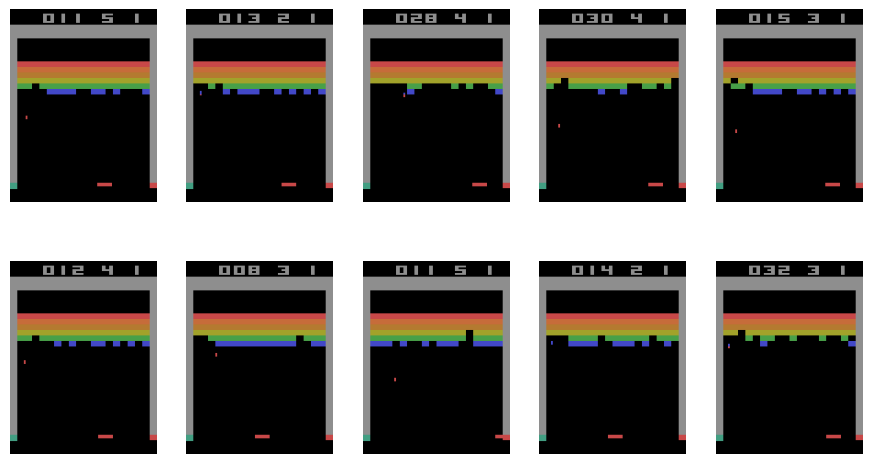

In [15]:
sort_images(ball_low, ball_left_coef - ball_low_coef)

### Ball left - Ball low + Reward

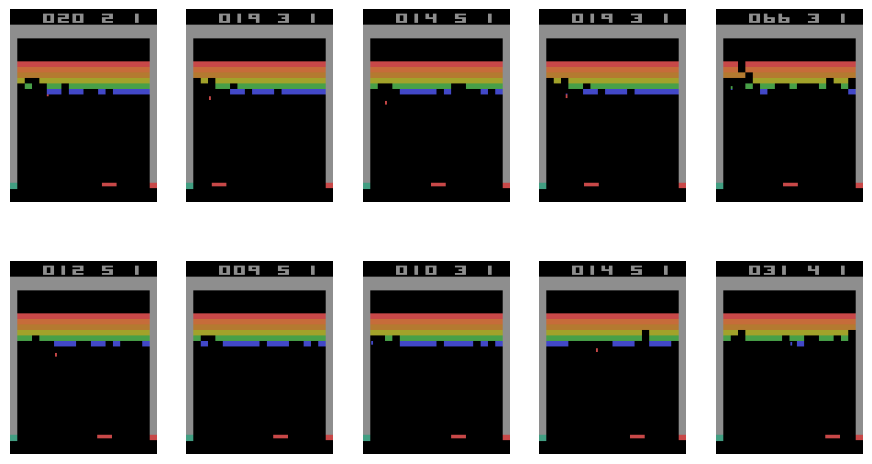

In [16]:
sort_images(reward, ball_left_coef - ball_low_coef + reward_coef)

### Ball left - Ball low - Reward

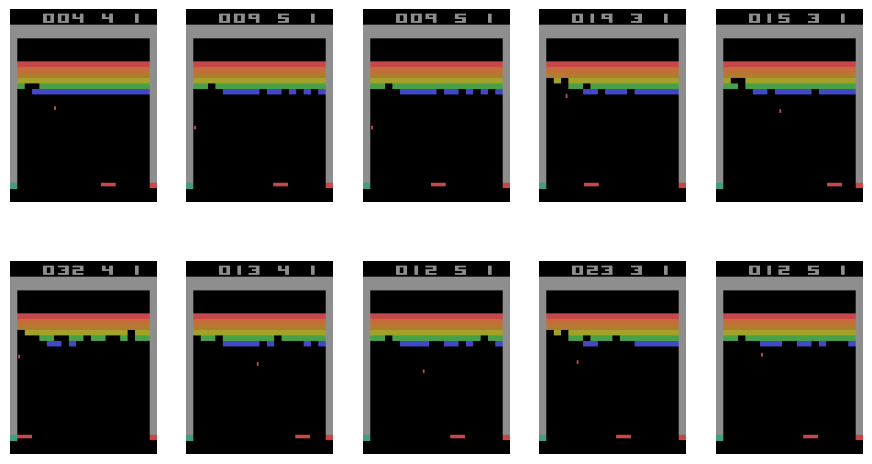

In [17]:
sort_images(reward, ball_left_coef - ball_low_coef - reward_coef)

### Bricks hit + paddle right + ball low

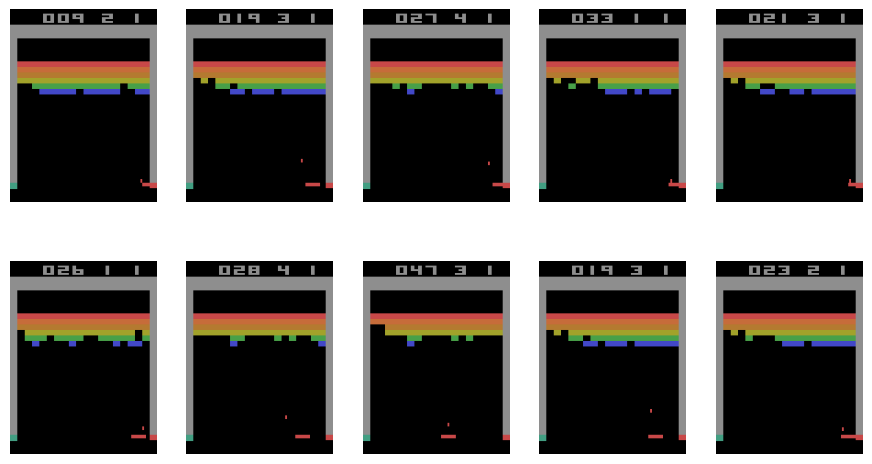

In [28]:
sort_images(bricks_hit, bricks_hit_coef + paddle_right_coef + ball_low_coef)

### Paddle right - bricks hit

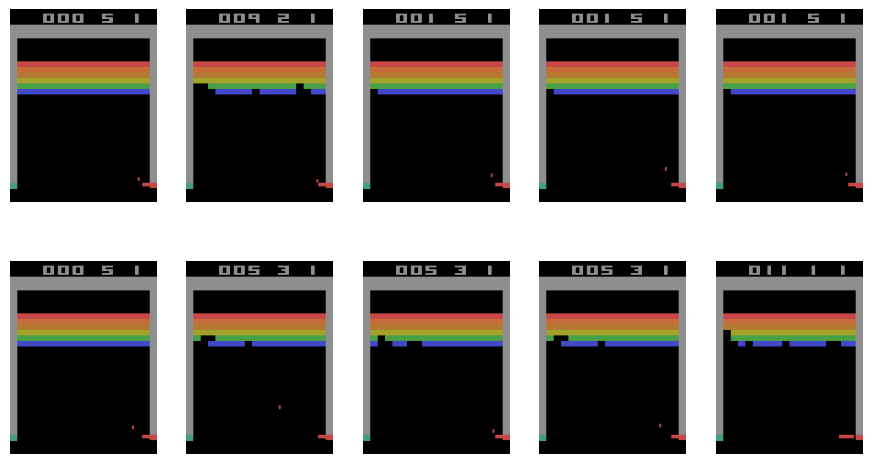

In [19]:
sort_images(bricks_hit, paddle_right_coef - bricks_hit_coef)